## Preprocessing

In [3]:
import pandas as pd
df = pd.read_csv("icliniq.csv")

questions = df["Extracted_Question"].values.tolist()
answers = df["Extracted_Answer"].values.tolist()

### Finding the cutoff pnt!

1779
140.8910851149657
93.0
215


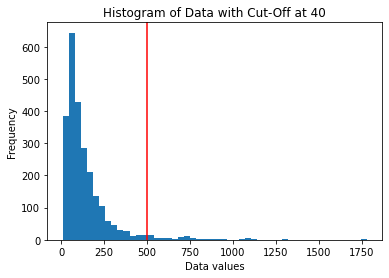

In [6]:
import numpy as np
maxi = []
for k in range(len(questions)):
    question = "Question: " + str(questions[k]) + "\n\n"
    answer = "Answer: " + str(answers[k]) + "\n"

    final = question + answer
    maxi.append(len(final.split()))
      
    
print(max(maxi))
print(np.mean(maxi))
print(np.median(maxi))
above_230 = [x for x in maxi if x > 300]

# Use the len() function to count how many numbers are in the new list
count = len(above_230)
print(count)

import matplotlib.pyplot as plt
import numpy as np
plt.hist(maxi, bins=50)

# Add a vertical line to show the cut-off number
plt.axvline(x=500, color='red')

# Add labels and a title
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.title('Histogram of Data with Cut-Off at 40')

# Display the plot
plt.show()

In [7]:
import numpy as np
dataset = []
CUTOFF = 150
for k in range(len(questions)):
    question = "Question: " + str(questions[k]) + "\n\n"
    answer = "Answer: " + str(answers[k]) + "\n"
    final = question + answer

    dataset.append(final)

In [8]:
dataset[5]

'Question: What are the symptoms of Neurofibromatosis-Noonan syndrome ? (Also called: NFNS; Noonan neurofibromatosis syndrome; Neurofibromatosis with Noonan phenotype; Neurofibromatosis)\n\nAnswer: What are the signs and symptoms of Neurofibromatosis-Noonan syndrome? The Human Phenotype Ontology provides the following list of signs and symptoms for Neurofibromatosis-Noonan syndrome. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the helix 90% Abnormality of the pulmonary valve 90% Aplasia/Hypoplasia of the abdominal wall musculature 90% Cafe-au-lait spot 90% Cognitive impairment 90% Hypertelorism 90% Hypertrophic cardiomyopathy 90% Low-set, posteriorly rotated ears 90% Ptosis 90% Short stature 90% Webbed neck 90% Abnormality of coagulati

## Bloom Preprocessing

In [9]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [10]:
from datasets import Dataset, DatasetDict

train_dict ={ 
    "text": train_dataset,
}
train_dataset = Dataset.from_dict(train_dict)


test_dict ={ 
    "text": test_dataset,
}
test_dataset = Dataset.from_dict(test_dict)


dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [12]:
import torch
torch.cuda.empty_cache()

# Training

## Importing Bloom model to train

In [13]:
from transformers import BloomTokenizerFast, BloomForCausalLM
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

model_id="bigscience/bloom-560m"

tokenizer = BloomTokenizerFast.from_pretrained(model_id)
model = BloomForCausalLM.from_pretrained("bloom3b-finetuned-medQuad/checkpoint-2783")

In [14]:
# CUTOFF = 500
CUTOFF = 150

## Preprocessing (Tokenization)

In [15]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=CUTOFF)

In [16]:
tokenized_dataset = dataset.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

Map (num_proc=8):   0%|          | 0/1983 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/496 [00:00<?, ? examples/s]

In [17]:
assert len(tokenized_dataset["train"][0]["input_ids"]) == CUTOFF
assert len(tokenized_dataset["test"][0]["input_ids"]) == CUTOFF

In [18]:
print(len(tokenized_dataset["train"][1]["input_ids"]))
print(len(tokenized_dataset["test"][1]["attention_mask"]))

150
150


### Applying truncation

In [19]:
block_size = CUTOFF
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
	k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [20]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=100,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/1983 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/496 [00:00<?, ? examples/s]

In [21]:
print(len(lm_datasets["train"][2]["input_ids"]))
print(len(lm_datasets["train"][2]["attention_mask"]))
print(len(lm_datasets["test"][2]["labels"]))

150
150
150


### Actual Training

In [22]:
training_args = TrainingArguments(
    f"bloom3b-finetuned-icliniq",
    per_device_train_batch_size=4,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    optim="adafactor",
    logging_steps=40,
    save_strategy='epoch',
    weight_decay=0.1,
    learning_rate=5e-6,
    evaluation_strategy='steps',
    eval_steps=400,
    tf32=False,
    per_device_eval_batch_size=4,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss


TrainOutput(global_step=372, training_loss=1.1730830464311826, metrics={'train_runtime': 545.3828, 'train_samples_per_second': 10.908, 'train_steps_per_second': 0.682, 'total_flos': 1618616560435200.0, 'train_loss': 1.1730830464311826, 'epoch': 3.0})

In [19]:
import torch
torch.cuda.empty_cache()

# Testing/Inference

### Importing the pretrained Model

In [15]:
from transformers import BloomTokenizerFast, BloomForCausalLM
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

model_id="bigscience/bloom-560m"

tokenizer = BloomTokenizerFast.from_pretrained(model_id)
model = BloomForCausalLM.from_pretrained("bloom3b-finetuned-icliniq/checkpoint-372")

### Create a generator using pipeline

In [16]:
from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = pipeline('text-generation', model=model.to(device),device = 0, tokenizer=tokenizer,do_sample=False)

### Unprocessed inference

In [9]:
with torch.no_grad():
    print(generator(preprocess("I have stomach problem. What is wrong?"), max_length=300))

[{'generated_text': '\n Question: I have stomach problem. What is wrong?\n\n Answer:  The stomach is a hollow, muscular organ that is located just below the stomach tube, just below the esophagus, and just below the stomach. The stomach is made up of two parts: a large, muscular stomach tube and a small, muscular stomach pouch. The stomach tube is made up of muscles and a tube called the esophagus. The pouch is made up of fat and lined with mucus. The stomach tube and pouch are connected by a tube called the esophagus. The esophagus carries food from the stomach to the small intestine. The esophagus and stomach tube are connected by a tube called the stomach. The stomach is the main stomach, which is where most of the food gets digested. The stomach is made up of two parts: a large, muscular stomach tube and a small, muscular stomach pouch. The stomach tube is made up of muscles and a tube called the esophagus. The pouch is made up of fat and lined with mucus. The stomach tube and pouc

### Preprocessing the output stuff

In [18]:
import re
from tqdm.notebook import tqdm
CUTOFF = 300
def preprocess(text):
    #We add 'Question :' and 'Answer #1:' at the start and end of the prompt
    return "\n Question: " + text + "\n\n Answer: "

def generate(text):
    preprocessed_text = preprocess(text)
    result = generator(preprocessed_text, max_length=CUTOFF)
    output = re.split(r'\n Question: |\n\n Answer:  ',result[0]['generated_text'])[2]
    return output

def preprocessList(texts):
    #We add 'Question :' and 'Answer #1:' at the start and end of the prompt
    for i in range(len(texts)):
        texts[i] = "\n Question: " + texts[i] + "\n\n Answer: "
    return texts

def generateList(texts):
    preprocessed_texts = preprocessList(texts)
    result = generator(preprocessed_texts, max_length=CUTOFF)
    print(result)
    return 1

def processResult(result):
    for i in tqdm(range(len(result))):
        result[i] = re.split(r'\n Question: |\n\n Answer:  ',result[i][0]['generated_text'])[2]
    return result

def generateDF(df):
    df = df.apply(preprocess)
    results = []
    for txt in tqdm(df.values.tolist()):
        with torch.no_grad():
            results.append(generator(txt, max_length=CUTOFF))
    output = processResult(results)
    return output

### Inferencing the test set

In [12]:
import pandas as pd
df = pd.read_csv("new_dataset.csv")

In [13]:
df.head()

,AnswerID,Answer,Extracted_Question,Extracted_Answer
0,ADAM_0003147_Sec1.txt,Question: What is (are) Polycystic ovary syndr...,What is (are) Polycystic ovary syndrome ? (Als...,Polycystic ovary syndrome is a condition in wh...
1,ADAM_0003147_Sec2.txt,Question: What causes Polycystic ovary syndrom...,What causes Polycystic ovary syndrome ? (Also ...,PCOS is linked to changes in hormone levels th...
2,ADAM_0002818_Sec2.txt,Question: What causes Noonan syndrome ?\nURL: ...,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...
3,ADAM_0002818_Sec7.txt,Question: What are the complications of Noonan...,What are the complications of Noonan syndrome ?,- Buildup of fluid in tissues of body (lymphed...
4,ADAM_0002818_Sec9.txt,Question: How to prevent Noonan syndrome ?\nUR...,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...


In [14]:
questions = df["Extracted_Question"]
answers = df["Extracted_Answer"]

In [15]:
answers.head()

0    Polycystic ovary syndrome is a condition in wh...
1    PCOS is linked to changes in hormone levels th...
2    Noonan syndrome is linked to defects in severa...
3    - Buildup of fluid in tissues of body (lymphed...
4    Couples with a family history of Noonan syndro...
Name: Extracted_Answer, dtype: object

In [20]:
len(answers)

2479

In [ ]:
pred_answers = generateDF(questions)

  0%|          | 0/2479 [00:00<?, ?it/s]

### Calculating BLEU and ROUGE metrics

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import  word_tokenize
import numpy as np
from rouge import Rouge

# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

rouge = Rouge()

# pred_caption = word_tokenize(pred_caption.lower())

ground_truth = answers.values.tolist()
generated_ans = pred_answers

Bleu1 = []
Bleu4 = []
rouge_1_score = []
rouge_2_score = []
rouge_L_score = []

for i in range(len(ground_truth)):
    grndAns = ground_truth[i]
    gen_ans = generated_ans[i]
    
    # BLEU SCORES
    gen_ans_ = word_tokenize(gen_ans.lower())
    grndAns_ = word_tokenize(grndAns.lower())
    bleu1 = bleu1(grndAns_, gen_ans_)
    bleu4 = bleu4(grndAns_, gen_ans_)
    Bleu1.append(bleu1)
    Bleu4.append(bleu4)
    
    # Rouge
    scores = rouge.get_scores(gen_ans, grndAns)
    r1s = scores[0]['rouge-1']['f'] # f1 score
    r2s = scores[0]['rouge-2']['f']
    rLs = scores[0]['rouge-l']['f']
    rouge_1_score.append(r1s)
    rouge_2_score.append(r2s)
    rouge_L_score.append(rLs)
    

print("BLEU 1 Gram: ", np.mean(Bleu1))
print("BLEU 4 Gram: ", np.mean(Bleu4))
print("ROUGE 1 Gram:", np.mean(rouge_1_score))
print("ROUGE 2 Gram:", np.mean(rouge_2_score))
print("ROUGE L Gram:", np.mean(rouge_L_score))

##